# Image Processing SS 20 - Assignment - 11 DRAFT

### Deadline is 08.07.2020 at 11:55am.

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [4]:
# display the plots inside the notebook
%matplotlib inline

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import astronaut
from skimage.color import rgb2gray, gray2rgb
import pywt
from PIL import Image

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Haar Matrix - 5 Points

Write a function to create a 2Nx2N dimensional Haar matrix.

Plot the 16x16 Haar matrix.



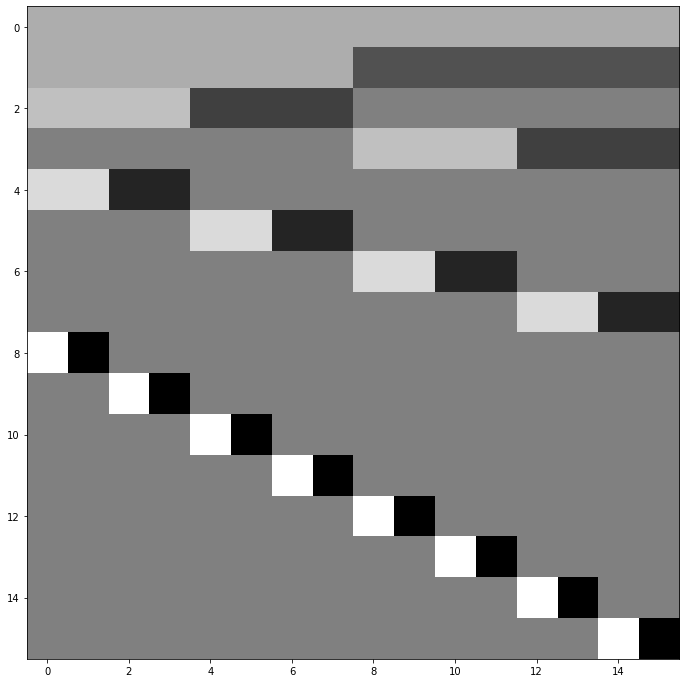

In [6]:
def haar_matrix(n):
    """Returns the Haar matrix. N is a power of two."""
    power = int(np.log2(n)) + 1
    h2 = np.array([[1,1],[1,-1]]) / np.sqrt(2)
    result = h2.copy()
    for i in range(2,power):
        up = np.kron(result,[1,1])
        down = np.kron(np.eye(result.shape[0]) , [1,-1])
        result = np.concatenate((up,down)) / np.sqrt(2)
    return result

 

plt.imshow(haar_matrix(16), cmap='gray')
plt.show()

# Exercise 2 - Reconstruction error of Haar Transformation - 5 Points

Use the matrix from exercise 1 to create the 2D-Haar-Wavelet spectrum of the cat (chelsea)
image - similar to 2D-DFT or 2D-DCT. Display the coefficients, i.e., the
result of your transformation.

Now Erase 75 percent of coefficients - the 75 percent lowest
coefficients by absolute value (set them to 0). Transform back, show the image and
calculate and output the average quadratic reconstruction error.

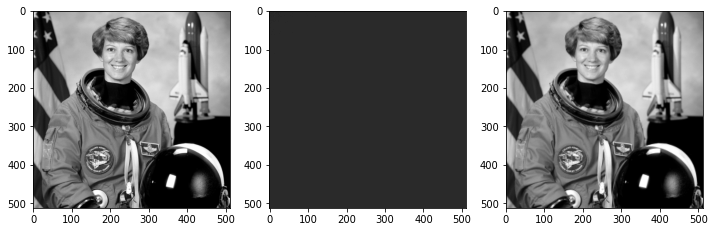

Average quadratic error: 0.0015345871796919024


In [7]:
def haar_trans_2d(img):
    N = img.shape[0]
    matrix = haar_matrix(N)
    (cA, (cH, cV, cD)) = pywt.dwt2(img, 'haar')
    up = np.concatenate((cA,cH), axis=1)
    down = np.concatenate((cV,cD), axis=1)
    res  = np.concatenate((up,down))
    return matrix @ img @ matrix.T

def haar_trans_2d_inv(coefficents):
    N = coefficents.shape[0]
    matrix = haar_matrix(N)
    return matrix.T @ coefficents @ matrix

def filter_coefficents(coefficents, factor=0.5): 
    eraseFactor = int(coefficents.shape[0] * factor)
    coefficents[eraseFactor:] = 0
    coefficents[:,eraseFactor:] = 0
    return coefficents

def avg_quadr_error(img1, img2):
    return np.sum((img1 - img2) ** 2) / (img1.shape[0] * img1.shape[1])



astro = rgb2gray(astronaut()) 
plt.subplot(131)
plt.imshow(astro, cmap="gray")

coeff = haar_trans_2d(astro)
plt.subplot(132)
plt.imshow(coeff * 10000, cmap='gray')

coeff_filtered = filter_coefficents(coeff)
astro_filtered = haar_trans_2d_inv(coeff_filtered)

plt.subplot(133)
plt.imshow(astro_filtered, cmap="gray")
plt.show()

print(
    "Average quadratic error: " 
    + str(avg_quadr_error(astro, astro_filtered))
)

# Exercise 3 - Blending - 10 Points

a) Blend two images (fore.png, back.png, see blending-images.zip in the resources folder in the WhiteBoard (KVV)), by using pyramid blending. You can grayscale all images in order to have only one channel.
Create two Laplace pyramids for the foreground and background image.
Create a Gaussian pyramid for the blending mask image alpha.png. Plot the lowest 3 levels of the three pyramids.
Then apply pyramid blending. Show the lowest 3 levels of the resulting Laplace pyramid and reconstruct the image. Show the blended image.

As an input you can use the images alpha.png, back.png, fore.png given  or use your own images.
You should not use any blending functions or functions which create the Laplacian or Gaussian pyramid for you. Feel free to use a method
of your own choice for the REDUCE and EXPAND function (see slides), especially for the interpolations.

b) Now blend, but not with the full pyramid as in a), instead use 2 levels and later 4 levels of the
Laplacian / Gaussian pyramid, which only contains 2 or 4 levels.

Plot the results (the blended images).


In [31]:
#https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf 
# Kernel from here ~ created the best results

kernel = np.array([
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25],
    [1/25, 1/25, 1/25, 1/25, 1/25] 
])

In [58]:
#Load Images
direc = 'misc/' # directory of the sample pictures relative to your notebook
front = np.array(Image.open(direc+'fore.png')) / 255
back  = np.array(Image.open(direc+'back.png')) / 255
mask  = np.array(Image.open(direc+'alpha.png')) / 255

front = rgb2gray(front)
back = rgb2gray(back)
mask = rgb2gray(mask)

In [21]:
def reduce_(img):
    x, y = img.shape[0]//2, img.shape[1]//2 
    result = np.zeros((x, y))
    for i in range(2, x-2):
        for j in range(2, y-2):
            pixel = 0
            for m in range(-2, 3):
                for n in range(-2, 3):
                    pixel += kernel[m,n] * img[2*i-m, 2*j-n]
            result[i,j] = pixel
    return result

def expand_(img):
    x, y = img.shape[0]*2, img.shape[1]*2
    result = np.zeros((x,y))
    for i in range(2, x-2):
        for j in range(2, y-2):
            pixel = 0
            for m in range(-2, 3):
                for n in range(-2, 3):
                    pixel += kernel[m,n] * img[(i-m)//2, (j-n)//2]
            result[i,j] = pixel # if we multiply with 4, values become greater 1 
    return result

def gaussian_pyramid(img):
    tmp = img.copy()
    result = []
    result.append(tmp)
    while tmp.shape[0] != 32:
        tmp = reduce_(tmp)
        result.append(tmp)
    return result

def laplace_pyramid(lis):
    result = []
    for i in range(len(lis)-1):
        first = lis[i]
        second = lis[i+1]
        second = expand_(second)
        result.append(first - second)
    return result

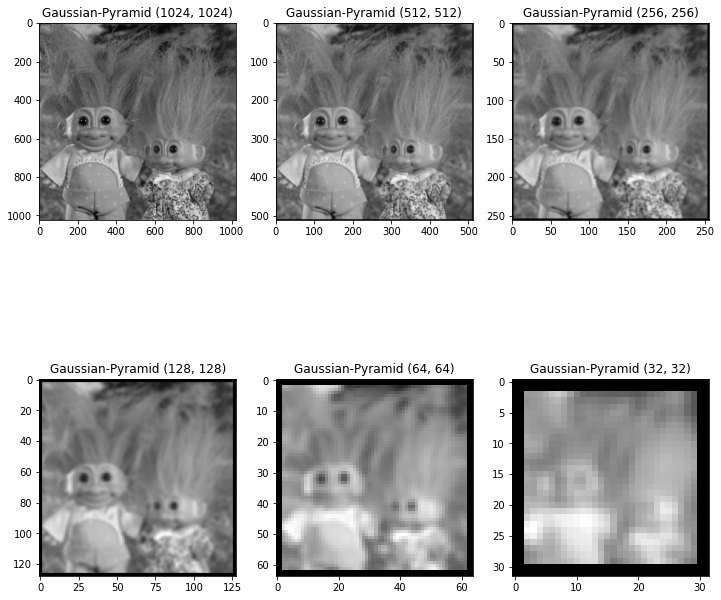

In [64]:
g_pyramids_front = gaussian_pyramid(front)
k = len(g_pyramids) * 10//2
numb = 201 + k
for i in range(len(g_pyramids)):
    plt.subplot(numb)
    plt.title("Gaussian-Pyramid " + str(g_pyramids_front[i].shape))
    plt.imshow(g_pyramids_front[i], cmap="gray")
    numb += 1
plt.show()

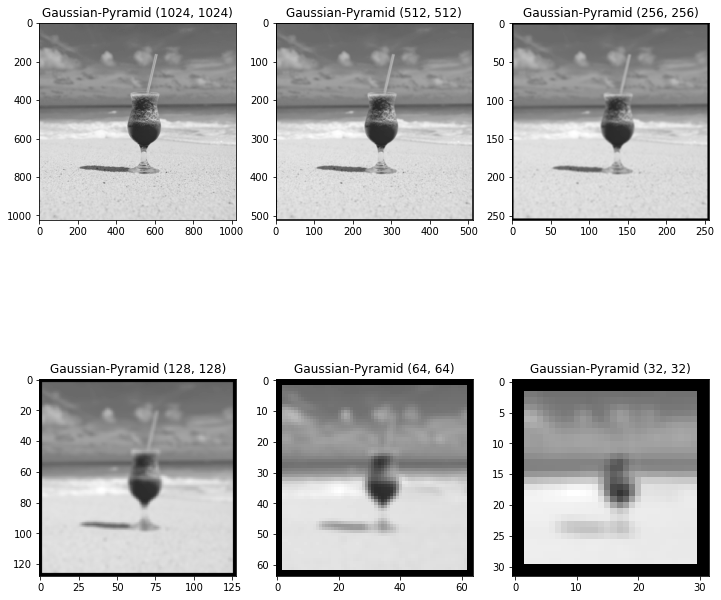

In [67]:
g_pyramids_back = gaussian_pyramid(back)
k = len(g_pyramids) * 10//2
numb = 201 + k
for i in range(len(g_pyramids)):
    plt.subplot(numb)
    plt.title("Gaussian-Pyramid " + str(g_pyramids_back[i].shape))
    plt.imshow(g_pyramids_back[i], cmap="gray")
    numb += 1
plt.show()

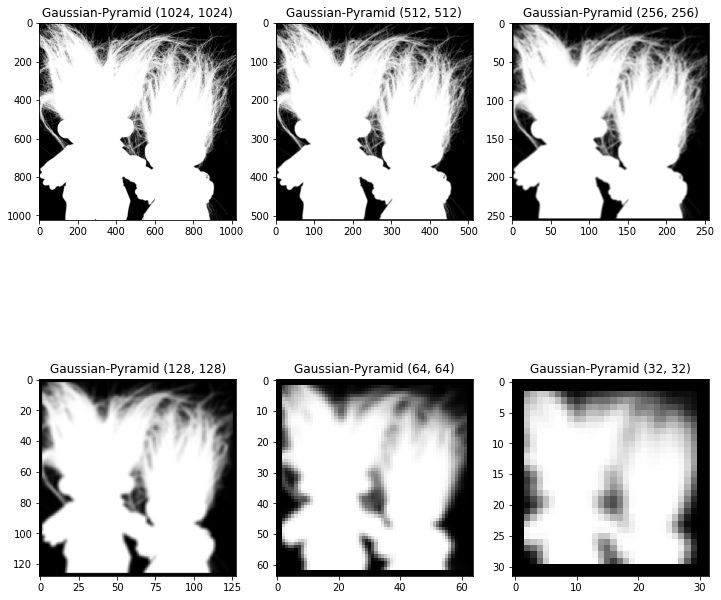

In [65]:
g_pyramids_mask = gaussian_pyramid(mask)
k = len(g_pyramids) * 10//2
numb = 201 + k
for i in range(len(g_pyramids)):
    plt.subplot(numb)
    plt.title("Gaussian-Pyramid " + str(g_pyramids_mask[i].shape))
    plt.imshow(g_pyramids_mask[i], cmap="gray")
    numb += 1
plt.show()

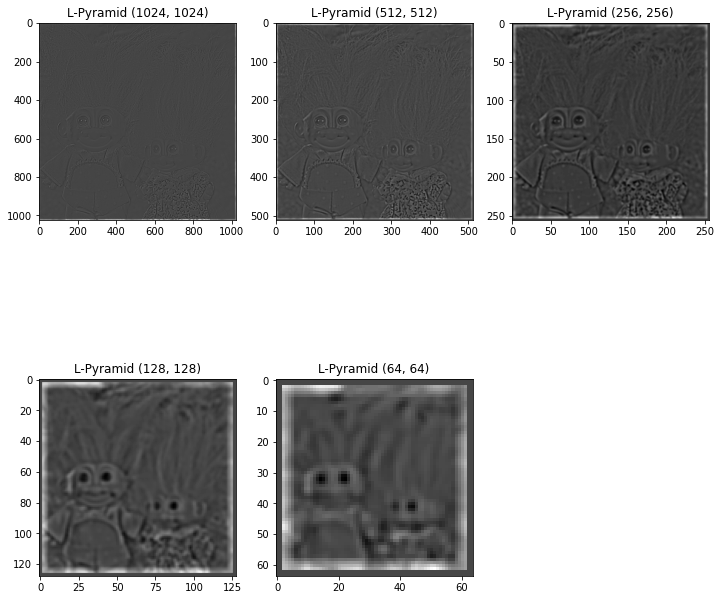

In [68]:
l_pyramids_front = laplace_pyramid(g_pyramids_front)
k = len(g_pyramids_front) * 10 // 2
numb = 201 + k
for i in range(len(l_pyramids_front)):
    plt.subplot(numb)
    plt.title("L-Pyramid " + str(l_pyramids_front[i].shape))
    plt.imshow(l_pyramids_front[i], cmap="gray")
    numb += 1
plt.show()

30


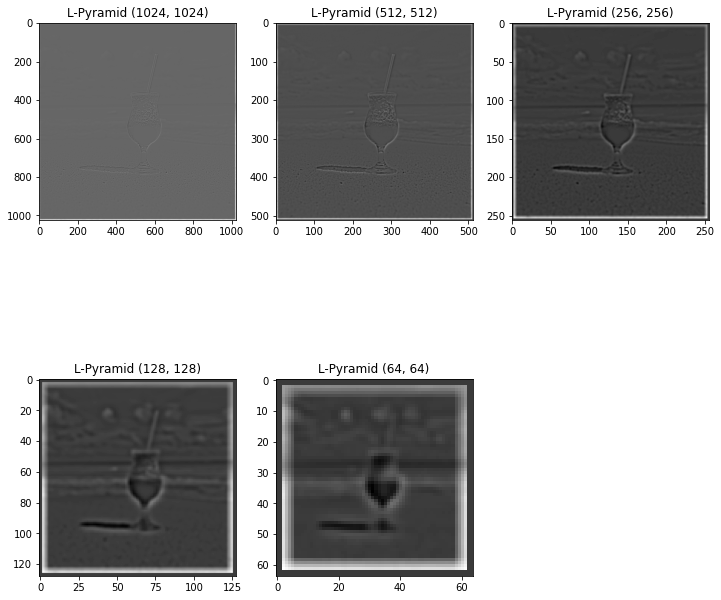

In [83]:
l_pyramids_back = laplace_pyramid(g_pyramids_back)
k = len(g_pyramids_back) * 10 // 2
numb = 201 + k
for i in range(len(l_pyramids_back)):
    plt.subplot(numb)
    plt.title("L-Pyramid " + str(l_pyramids_back[i].shape))
    plt.imshow(l_pyramids_back[i], cmap="gray")
    numb += 1
plt.show()

In [73]:
#blending algorith
def blending(g_mask, l_front, l_back):
    x, y = g_mask.shape[0], g_mask.shape[1]
    result = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            result[i,j] = g_mask[i,j]*l_front[i,j] + (1-g_mask[i,j])*l_back[i,j]
    return result

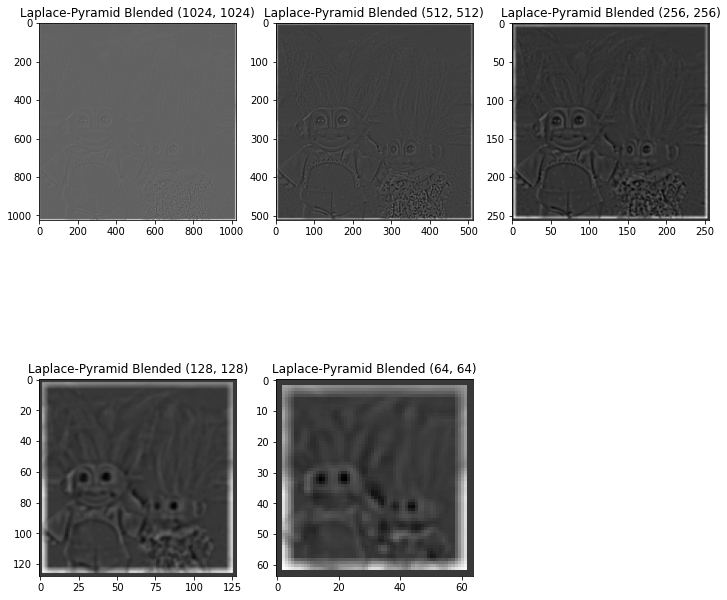

In [86]:
l_blended = []
for i in range(len(l_pyramids_front)):
    l_blended.append(blending(g_pyramids_mask[i], l_pyramids_front[i], l_pyramids_back[i]))

# plt.imshow(result[0], cmap="gray")
# plt.show()


k = len(l_blended) * 10 // 2 + 5 # +5 to be able to plot 3 in row
numb = 201 + k
for i in range(len(l_blended)):
    plt.subplot(numb)
    plt.title("Laplace-Pyramid Blended " + str(result[i].shape))
    plt.imshow(l_blended[i], cmap="gray")
    numb += 1
plt.show()

In [103]:
def reconstruct_image(l_blended):
    result = []
    reconstruct = l_blended[0]
    for i in range(1, len(l_blended)):
       reconstruct = expand_(reconstruct)
       reconstruct = l_blended[i] + reconstruct
       result.append(reconstruct)
    return result

In [104]:
print(len(reconstruct_image(l_blended)))

ValueError: operands could not be broadcast together with shapes (512,512) (2048,2048) 

In [70]:
# l_pyramids = laplace_pyramid(g_pyramids)
# k = len(g_pyramids) * 10
# numb = 101 + k
# for i in range(len(l_pyramids)):
#     plt.subplot(numb)
#     plt.title("L-Pyramid " + str(l_pyramids[i].shape))
#     plt.imshow(l_pyramids[i], cmap="gray")
#     numb += 1
# plt.show()

In [25]:
# diff = astro-ex
# print(np.amin(diff))
# value = 0
# for i in range(diff.shape[0]):
#     for j in range(diff.shape[0]):
#         if diff[i,j] < 0:
#             value += 1 
#             diff[i,j] = 0 
# print(value)